<a href="https://colab.research.google.com/github/gitHubAndyLee2020/OpenAI_Gym_Atari_Space_Invaders_RL/blob/main/openai_gym_space_invaders_a2c.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Space Invaders A2C Agent

In [ ]:
!pip install gym[atari]
!pip install autorom[accept-rom-license]

!pip install pyvirtualdisplay
!apt-get install -y xvfb python-opengl ffmpeg

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.6/1.6 MB 17.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 434.7/434.7 kB 4.6 MB/s eta 0:00:00
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Preparing metadata (pyproject.toml) ... done
  Created wheel for AutoROM.accept-rom-license: filename=AutoROM.accept_rom_license-0.6.1-py3-none-any.whl size=446660 sha256=a2f3805a7e8df4091efe6e628a4564380ec6eddbbd3d86300e4eedbdffed6154
  Stored in directory: /root/.cache/pip/wheels/6b/1b/ef/a43ff1a2f1736d5711faa1ba4c1f61be1131b8899e6a057811
Successfully built AutoROM.accept-rom-license
Reading package lists... Done
Building dependency tree... Done
Reading state information... Done
E: Unable to locate package python-opengl


In [ ]:
!apt-get install xvfb
!pip install xvfbwrapper

Reading package lists... Done
Building dependency tree... Done
Reading state information... Done
The following additional packages will be installed:
  libfontenc1 libxfont2 libxkbfile1 x11-xkb-utils xfonts-base xfonts-encodings
  xfonts-utils xserver-common
The following NEW packages will be installed:
  libfontenc1 libxfont2 libxkbfile1 x11-xkb-utils xfonts-base xfonts-encodings
  xfonts-utils xserver-common xvfb
0 upgraded, 9 newly installed, 0 to remove and 18 not upgraded.
Need to get 7,812 kB of archives.
After this operation, 11.9 MB of additional disk space will be used.
Get:1 http://archive.ubuntu.com/ubuntu jammy/main amd64 libfontenc1 amd64 1:1.1.4-1build3 [14.7 kB]
Get:2 http://archive.ubuntu.com/ubuntu jammy/main amd64 libxfont2 amd64 1:2.0.5-1build1 [94.5 kB]
Get:3 http://archive.ubuntu.com/ubuntu jammy/main amd64 libxkbfile1 amd64 1:1.1.0-1build3 [71.8 kB]
Get:4 http://archive.ubuntu.com/ubuntu jammy/main amd64 x11-xkb-utils amd64 7.7+5build4 [172 kB]
Get:5 http://archiv

In [ ]:
import numpy as np
import gym
import matplotlib.pyplot as plt
import cv2
from tensorflow.keras.layers import Dense, Input
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam
import time

In [ ]:
def prepro(I):
  """prepro 210x160x3 frame into 168x168, then downscale to 84x84 1D float vector"""
  I = I[27:195] # crop to 168x160
  I = I[:,:,0]  # Convert to grayscale by taking one channel

  # Add 4 black pixels on each side to make it 168x168
  I = cv2.copyMakeBorder(I, 0, 0, 4, 4, cv2.BORDER_CONSTANT, value=0)

  # Downscale to 84x84
  I = cv2.resize(I, (84, 84), interpolation=cv2.INTER_AREA)

  I[I == 0] = 0 # You may need to change this value based on the actual background color in Space Invaders
  I[I != 0] = 1  # Set all other (non-zero) pixels to 1

  return I.astype(np.float).ravel()

In [ ]:
def discount_rewards(r, gamma):
  """take 1D float array of rewards and compute discounted reward"""
  r = np.array(r)
  discounted_r = np.zeros_like(r)
  running_add = 0

  for t in reversed(range(0, r.size)):
    if r[t] != 0:
      running_add = 0 # if the game ended (in Pong), reset
    running_add = running_add * gamma + r[t]
    discounted_r[t] = running_add

  discounted_r -= np.mean(discounted_r) #normalizing the result
  discounted_r /= np.std(discounted_r) #idem using standar deviation
  return discounted_r

In [ ]:
# Initialize Environment
env = gym.make("SpaceInvaders-v0")
observation = env.reset()

# Constants
FIRE_ACTION = 1
RIGHT_ACTION = 2
LEFT_ACTION = 3
input_dim = 84 * 84  # Same as original
gamma = 0.99

/usr/local/lib/python3.10/dist-packages/gym/envs/registration.py:593: UserWarning: WARN: The environment SpaceInvaders-v0 is out of date. You should consider upgrading to version `v4`.
  logger.warn(
/usr/local/lib/python3.10/dist-packages/gym/core.py:317: DeprecationWarning: WARN: Initializing wrapper in old step API which returns one bool instead of two. It is recommended to set `new_step_api=True` to use new step API. This will be the default behaviour in future.
  deprecation(
/usr/local/lib/python3.10/dist-packages/gym/wrappers/step_api_compatibility.py:39: DeprecationWarning: WARN: Initializing environment in old step API which returns one bool instead of two. It is recommended to set `new_step_api=True` to use new step API. This will be the default behaviour in future.
  deprecation(


In [ ]:
# Actor Model Initialization
input_layer = Input(shape=(input_dim,))
hidden_layer_actor = Dense(units=200, activation='relu', kernel_initializer='glorot_uniform')(input_layer)
output_layer_actor = Dense(units=3, activation='softmax', kernel_initializer='RandomNormal')(hidden_layer_actor)
actor_model = Model(inputs=[input_layer], outputs=[output_layer_actor])

# Critic Model Initialization
hidden_layer_critic = Dense(units=200, activation='relu', kernel_initializer='glorot_uniform')(input_layer)
output_layer_critic = Dense(units=1, activation='linear', kernel_initializer='RandomNormal')(hidden_layer_critic)
critic_model = Model(inputs=[input_layer], outputs=[output_layer_critic])

# Compile Models
actor_model.compile(loss='categorical_crossentropy', optimizer=Adam(), metrics=['accuracy'])
critic_model.compile(loss='mse', optimizer=Adam())

In [ ]:
# Training Initialization
x_train, y_train, rewards = [], [], []
reward_sum = 0
episode_nb = 0
observation = env.reset()
prev_input = None
num_epochs = 50  # You can change this

/usr/local/lib/python3.10/dist-packages/gym/wrappers/monitoring/video_recorder.py:78: DeprecationWarning: WARN: Recording ability for environment SpaceInvaders-v0 initialized with `render_mode=None` is marked as deprecated and will be removed in the future.
  logger.deprecation(


In [23]:
# Initialize time and history tracking
start_time = time.time()
time_history = []
reward_history = []

# Main Training Loop
while episode_nb < num_epochs:
    cur_input = prepro(observation)
    x = cur_input - prev_input if prev_input is not None else np.zeros(input_dim)
    prev_input = cur_input

    proba = actor_model.predict(np.expand_dims(x, axis=0))
    action = np.random.choice([FIRE_ACTION, RIGHT_ACTION, LEFT_ACTION], p=proba.ravel())
    y = np.zeros(3)
    y[action - 1] = 1

    x_train.append(x)
    y_train.append(y)

    observation, reward, done, info = env.step(action)
    rewards.append(reward)
    reward_sum += reward

    if done:
        episode_time = time.time() - start_time
        print(f'At the end of episode {episode_nb}, the total reward was: {reward_sum}. Time taken: {episode_time} seconds')

        # Store time and reward into history
        time_history.append(episode_time)
        reward_history.append(reward_sum)

        # Compute discounted rewards
        discounted_rewards = discount_rewards(rewards, gamma)

        # Compute value predictions from critic model
        value_preds = critic_model.predict(np.vstack(x_train))

        # Compute advantages
        advantages = discounted_rewards - value_preds.ravel()

        # Train actor model
        actor_model.fit(x=np.vstack(x_train), y=np.vstack(y_train), verbose=1, sample_weight=advantages)

        # Train critic model
        critic_model.fit(x=np.vstack(x_train), y=discounted_rewards, verbose=1)

        # Reset for next episode
        x_train, y_train, rewards = [], [], []
        observation = env.reset()
        reward_sum = 0
        prev_input = None
        episode_nb += 1

        # Reset start_time for next episode
        start_time = time.time()

1/1 [==============================] - ETA: 0s

<ipython-input-4-3501ac0a60b8>:15: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  return I.astype(np.float).ravel()
/usr/local/lib/python3.10/dist-packages/gym/core.py:43: DeprecationWarning: WARN: The argument mode in render method is deprecated; use render_mode during environment initialization instead.
See here for more information: https://www.gymlibrary.ml/content/api/
  deprecation(


1/1 [==============================] - 0s 19ms/step
At the end of episode 0, the total reward was: 155.0. Time taken: 33.769278049468994 seconds
1/1 [==============================] - 0s 19ms/step
At the end of episode 1, the total reward was: 120.0. Time taken: 42.50621438026428 seconds
1/1 [==============================] - 0s 20ms/step
At the end of episode 2, the total reward was: 75.0. Time taken: 31.6884765625 seconds
1/1 [==============================] - 0s 18ms/step
At the end of episode 3, the total reward was: 105.0. Time taken: 39.214457511901855 seconds
1/1 [==============================] - 0s 19ms/step
At the end of episode 4, the total reward was: 360.0. Time taken: 45.78942060470581 seconds
1/1 [==============================] - 0s 18ms/step
At the end of episode 5, the total reward was: 195.0. Time taken: 43.40286731719971 seconds
1/1 [==============================] - 0s 17ms/step
At the end of episode 6, the total reward was: 30.0. Time taken: 25.50900411605835 seco

/usr/local/lib/python3.10/dist-packages/gym/wrappers/monitoring/video_recorder.py:78: DeprecationWarning: WARN: Recording ability for environment SpaceInvaders-v0 initialized with `render_mode=None` is marked as deprecated and will be removed in the future.
  logger.deprecation(


1/1 [==============================] - 0s 18ms/step


/usr/local/lib/python3.10/dist-packages/gym/core.py:43: DeprecationWarning: WARN: The argument mode in render method is deprecated; use render_mode during environment initialization instead.
See here for more information: https://www.gymlibrary.ml/content/api/
  deprecation(
<ipython-input-4-3501ac0a60b8>:15: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  return I.astype(np.float).ravel()


Streaming output truncated to the last 5000 lines.
1/1 [==============================] - 0s 19ms/step
At the end of episode 19, the total reward was: 105.0. Time taken: 37.35011911392212 seconds
1/1 [==============================] - 0s 19ms/step
At the end of episode 20, the total reward was: 210.0. Time taken: 46.813210010528564 seconds
1/1 [==============================] - 0s 20ms/step
At the end of episode 21, the total reward was: 45.0. Time taken: 19.82956027984619 seconds
1/1 [==============================] - 0s 18ms/step
At the end of episode 22, the total reward was: 110.0. Time taken: 38.6097629070282 seconds
1/1 [==============================] - 0s 18ms/step
At the end of episode 23, the total reward was: 110.0. Time taken: 40.418187856674194 seconds
1/1 [==============================] - 0s 21ms/step
At the end of episode 24, the total reward was: 295.0. Time taken: 58.87443780899048 seconds
1/1 [==============================] - 0s 18ms/step


/usr/local/lib/python3.10/dist-packages/gym/wrappers/monitoring/video_recorder.py:78: DeprecationWarning: WARN: Recording ability for environment SpaceInvaders-v0 initialized with `render_mode=None` is marked as deprecated and will be removed in the future.
  logger.deprecation(


At the end of episode 25, the total reward was: 190.0. Time taken: 39.911757946014404 seconds
1/1 [==============================] - 0s 19ms/step


/usr/local/lib/python3.10/dist-packages/gym/core.py:43: DeprecationWarning: WARN: The argument mode in render method is deprecated; use render_mode during environment initialization instead.
See here for more information: https://www.gymlibrary.ml/content/api/
  deprecation(
<ipython-input-4-3501ac0a60b8>:15: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  return I.astype(np.float).ravel()


Streaming output truncated to the last 5000 lines.
1/1 [==============================] - 0s 19ms/step
At the end of episode 42, the total reward was: 190.0. Time taken: 63.21118402481079 seconds
1/1 [==============================] - 0s 19ms/step
At the end of episode 43, the total reward was: 85.0. Time taken: 31.439342498779297 seconds
1/1 [==============================] - 0s 18ms/step
At the end of episode 44, the total reward was: 110.0. Time taken: 30.653594255447388 seconds
1/1 [==============================] - 0s 32ms/step
At the end of episode 45, the total reward was: 245.0. Time taken: 54.684717655181885 seconds
1/1 [==============================] - 0s 18ms/step
At the end of episode 46, the total reward was: 120.0. Time taken: 38.645634174346924 seconds
1/1 [==============================] - 0s 18ms/step
At the end of episode 47, the total reward was: 480.0. Time taken: 66.21803617477417 seconds
1/1 [==============================] - 0s 18ms/step
At the end of episode 48

In [24]:
# Saving reward_history to a text file
with open(f'reward_history_epochs_{num_epochs}.txt', 'w') as f:
    for reward in reward_history:
        f.write(f"{reward}\n")

# Saving time_history to a text file
with open(f'time_history_epochs_{num_epochs}.txt', 'w') as f:
    for episode_time in time_history:
        f.write(f"{episode_time}\n")

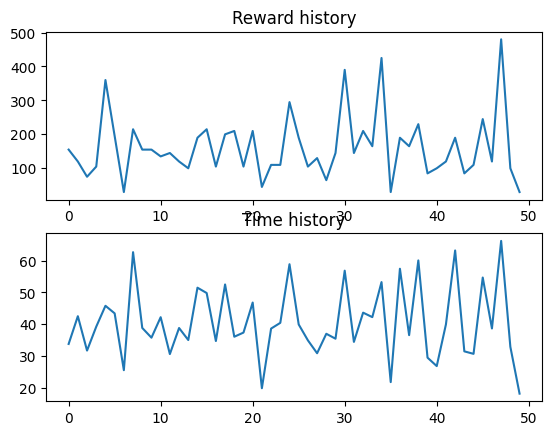

In [25]:
plt.subplot(2, 1, 1)
plt.plot(reward_history)
plt.title('Reward history')

plt.subplot(2, 1, 2)
plt.plot(time_history)
plt.title('Time history')

plt.show()

In [26]:
actor_model.save(f'actor_model_space_invaders_epochs_{num_epochs}.h5')
critic_model.save(f'critic_model_space_invaders_epochs_{num_epochs}.h5')

/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3000: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


In [27]:
from tensorflow.keras.models import load_model

loaded_actor_model = load_model(f'actor_model_space_invaders_epochs_{num_epochs}.h5')
loaded_critic_model = load_model(f'critic_model_space_invaders_epochs_{num_epochs}.h5')

In [29]:
import gym
from gym import logger as gymlogger
from gym.wrappers.record_video import RecordVideo
from pyvirtualdisplay import Display
import numpy as np
import glob
import io
import base64
from IPython.display import HTML
from IPython import display as ipythondisplay

# Utility functions for video recording
def show_video():
    mp4list = glob.glob('video/*.mp4')
    if len(mp4list) > 0:
        mp4 = mp4list[0]
        video = io.open(mp4, 'r+b').read()
        encoded = base64.b64encode(video)
        ipythondisplay.display(HTML(data='''<video alt="test" autoplay loop controls style="height: 400px;">
                    <source src="data:video/mp4;base64,{0}" type="video/mp4" />
                 </video>'''.format(encoded.decode('ascii'))))
    else:
        print("Could not find video")

def wrap_env(env):
    env = RecordVideo(env, './video')
    return env

# Initialize display
display = Display(visible=0, size=(1400, 900))
display.start()

# Create Space Invaders environment and wrap it for video recording
env = wrap_env(gym.make('SpaceInvaders-v0'))
observation = env.reset()
prev_input = None

# Main Loop for A2C model
while True:
    cur_input = prepro(observation)
    x = cur_input - prev_input if prev_input is not None else np.zeros(input_dim)
    prev_input = cur_input

    proba = actor_model.predict(np.expand_dims(x, axis=0))  # Changed `model` to `actor_model`
    action = np.random.choice([FIRE_ACTION, RIGHT_ACTION, LEFT_ACTION], p=proba.ravel())

    env.render()

    observation, reward, done, info = env.step(action)

    if done:
        break

# Close environment and display video
env.close()
show_video()

/usr/local/lib/python3.10/dist-packages/gym/envs/registration.py:593: UserWarning: WARN: The environment SpaceInvaders-v0 is out of date. You should consider upgrading to version `v4`.
  logger.warn(
/usr/local/lib/python3.10/dist-packages/gym/core.py:317: DeprecationWarning: WARN: Initializing wrapper in old step API which returns one bool instead of two. It is recommended to set `new_step_api=True` to use new step API. This will be the default behaviour in future.
  deprecation(
/usr/local/lib/python3.10/dist-packages/gym/wrappers/step_api_compatibility.py:39: DeprecationWarning: WARN: Initializing environment in old step API which returns one bool instead of two. It is recommended to set `new_step_api=True` to use new step API. This will be the default behaviour in future.
  deprecation(
/usr/local/lib/python3.10/dist-packages/gym/wrappers/record_video.py:78: UserWarning: WARN: Overwriting existing videos at /content/video folder (try specifying a different `video_folder` for the `R

1/1 [==============================] - ETA: 0s

<ipython-input-4-3501ac0a60b8>:15: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  return I.astype(np.float).ravel()
/usr/local/lib/python3.10/dist-packages/gym/core.py:49: DeprecationWarning: WARN: You are calling render method, but you didn't specified the argument render_mode at environment initialization. To maintain backward compatibility, the environment will render in human mode.
If you want to render in human mode, initialize the environment in this way: gym.make('EnvName', render_mode='human') and don't call the render method.
See here for more information: https://www.gymlibrary.ml/content/api/
  deprecation(
/usr/local/lib/python3.10/dist-packages/gym/u

1/1 [==============================] - 0s 19ms/step
